In [1]:
#%matplotlib inline
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# UPDATE THE PATH BELOW TO THE CODE FOLDER

In [2]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

# Load stuff

In [3]:
#These are the times (in units of the behaviour system bin running @1000Hz) at which spikes occurred

selected_session = 0

all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


#This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

#This is basically a big table (you can open it in excel) which contains
#relevant information about each time the animal poked one of the ports
task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

#
response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
#alternatively to change the time window


#not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
single_units = np.load(os.path.join(root_dir,'single_units.npy'))

In [4]:
#np.unique(task_event_df['graph_type'])

In [5]:
seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))

In [6]:
graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
graph_type1 = task_event_df.loc[task_event_df['task_nr']==1]['graph_type'].values[0]
print(graph_type0,graph_type1)

loop loop


In [7]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = n_states
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):
                
                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &    #task_nr was task
                                                (task_event_df['correct']==True) &    #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index  
                if direction==1:
                    print(port,task_event_df.loc[table_index-1])
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [8]:
from scipy.optimize import minimize

def skew_sym_regress(X, X_dot, tol=1e-8):
    """
    Original data tensor is C x L x N where N is number of Neurons, L is length of each trial
    and C is number of conditions. We stack this to get L*C x N array.
    Args
    ----
    X_dot: First difference of (reduced dimension) data. Shape is T x N

    X: reduced dimension data. Shape is T x N
    """

    # 1) Initialize h using the odd part of the least-squares solution.
    # 2) call scipy.optimize.minimize and pass in our starting h, and x_dot, 
    T, N = X.shape
    M_lstq, _, _, _ = np.linalg.lstsq(X, X_dot, rcond=None)
    M_lstq = M_lstq.T
    M_init = 0.5 * (M_lstq - M_lstq.T)
    h_init = _reshape_mat2vec(M_init, N)

    options=dict(maxiter=10000, gtol=tol)
    result = minimize(lambda h: _objective(h, X, X_dot),
                    h_init,
                    jac=lambda h: _grad_f(h, X, X_dot),
                    method='CG',
                    options=options)
    if not result.success:
        print("Optimization failed.")
        print(result.message)
    M = _reshape_vec2mat(result.x, N)
    assert(np.allclose(M, -M.T))
    return M

In [9]:


def _grad_f(h, X, X_dot):
    _, N = X.shape
    M = _reshape_vec2mat(h, N)
    dM = (X.T @ X @ M.T) - X.T @ X_dot
    return _reshape_mat2vec(dM.T - dM, N)


def _objective(h, X, X_dot):
    _, N = X.shape
    M = _reshape_vec2mat(h, N)
    return 0.5 * np.linalg.norm(X @ M.T - X_dot, ord='fro')**2


def _reshape_vec2mat(h, N):
    M = np.zeros((N, N))
    upper_tri_indices = np.triu_indices(N, k=1)
    M[upper_tri_indices] = h
    return M - M.T


def _reshape_mat2vec(M, N):
    upper_tri_indices = np.triu_indices(N, k=1)
    return M[upper_tri_indices]

In [10]:
n_states = 9

In [11]:
firing_rate_maps = get_task_responses(task_event_df,response_table)

0      target  port  state  task_nr  direction  probe  correct  previous_port  \
365       7     7      4        0          1  False     True            NaN   
368       0     4      1        0          1  False    False            NaN   
393       7     7      4        0          1  False     True            NaN   
397       0     1      7        0          1  False    False            NaN   
701       0     4      1        0          1  False    False            NaN   
736       7     7      4        0          1  False     True            NaN   

     previous_state  reward  block_nr  task_repeat_nr  port_repeat  \
365             NaN    True         1               0         True   
368             NaN    True         1               0         True   
393             NaN   False         1               0        False   
397             NaN    True         1               0         True   
701             NaN    True         3               1         True   
736             NaN    T

In [12]:
n_neurons, n_ports, n_tasks, n_directions = firing_rate_maps.shape

In [13]:
spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))

In [14]:
#here subtract the spatial terms
mds_frm = firing_rate_maps - spatial_map[:,:,None,None]

In [15]:
mds_frm.shape

(135, 9, 2, 2)

In [16]:
from sklearn.decomposition import PCA

In [17]:
#mds_frm_flat = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])
#mds_frm_flat = np.hstack([mds_frm[:,:,0,0],mds_frm[:,:,0,1],mds_frm[:,:,1,0],mds_frm[:,:,1,1]])
mds_frm_flat = np.hstack([mds_frm[:,seq1,0,0],mds_frm[:,seq1,0,1],mds_frm[:,seq0,1,0],mds_frm[:,seq0,1,1]])

In [331]:
pca = PCA(n_components=8)
pc_act = pca.fit_transform(mds_frm_flat.T)[:,:]

In [332]:
state_representation = pc_act[:9].T
nDim,n_timepoints = state_representation.shape

In [352]:
#this will obviously work perfectly
Ahat = np.linalg.lstsq(state_representation[:,:-1].T,state_representation[:,1:].T,rcond=0)[0].T

In [353]:
#this will obviously work perfectly
Ahatinv = np.linalg.lstsq(state_representation[:,1:].T,state_representation[:,:-1].T,rcond=0)[0].T

In [358]:
Ah2 = (Ahat-Ahat.T)/2.
I = np.eye(len(Ah2))

In [370]:
Q = np.dot(np.linalg.inv(I+Ah2),(I-Ah2))
assert np.allclose(1,np.abs(np.linalg.eig(Q)[0]))

In [380]:
xs = [np.random.normal(size=8)]
for _ in range(100):
    xs.append(np.dot(Q,xs[-1]))
xs = np.array(xs)

In [382]:
#plt.plot(np.array(xs)[:,0])

In [376]:
(Ahat@state_representation)[:,0]

array([ 2.58150079, 12.70741723, -1.2804414 , -5.01319058,  0.83965777,
       -0.68251049,  1.66379275, -0.14005015])

In [336]:
state_representation[:,1]

array([  3.72827123, -10.87337469,  11.35044664,  -6.47565637,
        -4.69092624,   5.20636058,  -6.68369895,   4.99229181])

In [337]:
len(state_representation)

8

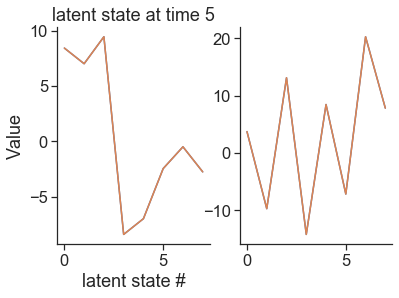

In [338]:
plt.subplot(1,2,1)
timePoint = 5
plt.title('latent state at time {}'.format(timePoint))
plt.plot((Ahat@state_representation)[:,timePoint-1],label='prediction of latent at timepoint {}'.format(timePoint))
plt.plot(state_representation[:,timePoint],label='state at timetpoint')
plt.xlabel("latent state #")
plt.ylabel("Value")

plt.subplot(1,2,2)
plt.plot((Ahat@state_representation)[0,:-1])
plt.plot(state_representation[0,1:])

seaborn.despine()

In [339]:
np.dot(Ahat,state_representation[:,0])

array([  3.72827123, -10.87337469,  11.35044664,  -6.47565637,
        -4.69092624,   5.20636058,  -6.68369895,   4.99229181])

In [340]:
state_representation[:,1]

array([  3.72827123, -10.87337469,  11.35044664,  -6.47565637,
        -4.69092624,   5.20636058,  -6.68369895,   4.99229181])

In [341]:
np.dot(Ahatinv,state_representation[:,1])

array([  1.40240577,   2.18587807,  -3.03329763, -18.33706143,
       -11.83697884,  -6.37050347,   0.96537632,   0.72208243])

In [342]:
state_representation[:,-1]

array([ 7.81824102, -1.53364715, -6.60422404,  6.11083759, -4.20794575,
        2.24323226,  0.76176977,  8.59084967])

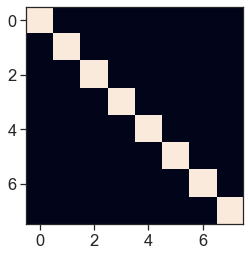

In [343]:
plt.imshow(np.dot(Ahat,Ahatinv))

# predict things going in the other task

In [344]:
#alt_task = pc_act[18:27][::-1].T
state_representation = pc_act[18:27].T

neural_activity = mds_frm_flat[:,18:27]


In [345]:
state_prediction = (Ahat@state_representation)[:,:-1]

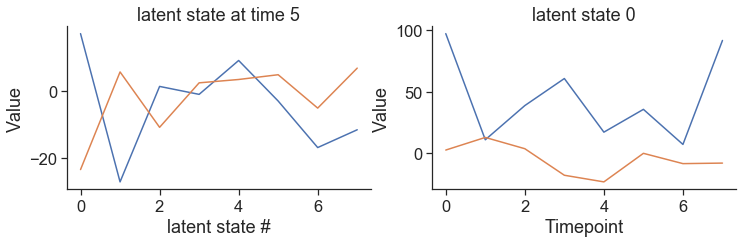

In [346]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
timePoint = 5
plt.title('latent state at time {}'.format(timePoint))
plt.plot((Ahat@state_representation)[:,timePoint-1],label='prediction of latent at timepoint {}'.format(timePoint))
plt.plot(state_representation[:,timePoint],label='state at timetpoint')
plt.xlabel("latent state #")
plt.ylabel("Value")

plt.subplot(1,2,2)
plt.title("latent state 0")
plt.plot((Ahat@state_representation)[0,:-1])
plt.plot(state_representation[0,1:])
plt.xlabel("Timepoint")
plt.ylabel("Value")

seaborn.despine()

In [347]:
mds_frm_flat.shape

(135, 36)

In [348]:
#.shape = (n_neurons,n_states)
neuron_prediction = pca.inverse_transform(state_prediction.T).T

In [349]:
ccs = []
for nix in range(neuron_prediction.shape[0]):
    cc_ = np.corrcoef(neuron_prediction[nix],neural_activity[nix,1:])[0,1]
    ccs.append(cc_)
    
ccs = np.array(ccs)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


-0.1380999021006281


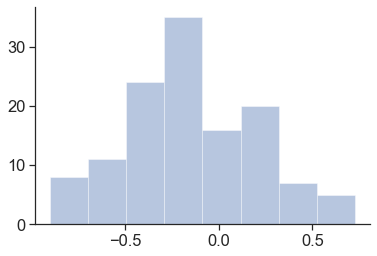

In [350]:
seaborn.distplot(ccs[np.isfinite(ccs)],kde=0)
seaborn.despine()
print(np.nanmean(ccs))

# Now reverse direction